# CS-472 Computer Vision
## Assignment 05: Particle Swarm Optimization Tracking
## By: <span style="color:orange">Ioannis Kaziales</span> ~ csdp1305
### Spring semester 2022-2023 (Due Date: 03/07/2023)

This file contains the implementation for **part C** (Video ellipse card tracking).
It utilizes some useful classes and functions from file `utils.py`.

If you want to see a visualization first, you can check the file `partC_demo.ipynb`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from utils import *

np.random.seed(42)

In [2]:
# ~~~~~~~~~~~~~~~~~~ Some parameters about the dataset ~~~~~~~~~~~~~~~~~~
SAVE_IMGS:  bool = False    # whether to save images to disk. It will be slower if True
SAVE_PREPR: bool = False    # whether to save the preprocessed images to disk. It will be slower if True
SAVE_TXTS:  bool = True     # whether to save the estimated parameters to txt files

in_dir  = "askisi5_dataset3"    # input directory
txt_dir = "results/txt/partC"   # output directory to store the txt files with the estimated parameters
prefix  = "colorFrame_0_"       # prefix of the input files
zero_padding = 5
start_frame, end_frame = 0, 654

if not os.path.exists(txt_dir):
    os.makedirs(txt_dir)

if SAVE_IMGS:
    img_dir = "results/imgs/partC"      # output directory to store the images with the circles overlaid
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

if SAVE_PREPR:
    prepr_dir = "results/preprocess/partC"    # output directory to store the preprocessed images
    if not os.path.exists(prepr_dir):
        os.makedirs(prepr_dir)

# 1st frame
### Find the Parameters with no prior knowledge

In [3]:
img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(start_frame).zfill(zero_padding)}.jpg"))
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
y_max, x_max = img.shape[:2]
max_axis = round(np.sqrt(x_max**2 + y_max**2) / 5) # max axis length is 1/5 of the diagonal of the image
max_angle = 180

max_position = [x_max, y_max, max_axis, max_axis, max_angle]

savefile = os.path.join(prepr_dir, f"{prefix}{str(start_frame).zfill(zero_padding)}.png") if SAVE_PREPR else None
img_preprocessed = preprocess_image_ellipse(img_gray, save_filename=savefile)

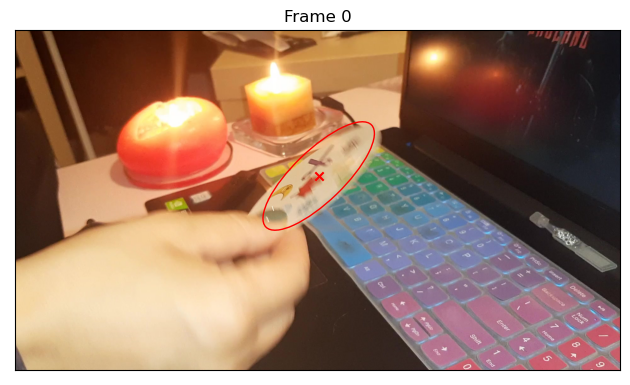

In [4]:
# PSO parameters for the first frame
num_particles   = 25
max_iterations  = 100
stop_iterations = 10    # stop if no improvement after 15 iterations
c1 = 1.0                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 1.0             # decay of inertia

particles = initialize_particles(img_preprocessed, num_particles, max_position)
optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations)
best_position, best_fitness, _ = optim.optimize(img_preprocessed, particles, max_position)

# swap the axes if the ellipse is rotated more than 90 degrees
if best_position[2] < best_position[3]:
    best_position[2], best_position[3] = best_position[3], best_position[2]
    best_position[4] = (best_position[4] + 90) % 180


if SAVE_TXTS:
    save_txt(os.path.join(txt_dir, f"{prefix}{start_frame}.txt"), estimated_params=best_position, type='ellipse')

# show the estimated ellipse
filename = os.path.join(img_dir, f"{prefix}{start_frame}.png") if SAVE_IMGS else None
plot_estimation(img, best_position, title=f"Frame {start_frame}", save_filename=filename, est_type='ellipse', rgb=True)

x, y, a, b, theta = best_position

## Some extra Plots
Essentially, we preprocess the image to get a simple white ellipse on a black background, run PSO on the generated preprocessed image (using mean Intersect over Union - mIoU as an evaluation function) and then plot the ellipse in the original image

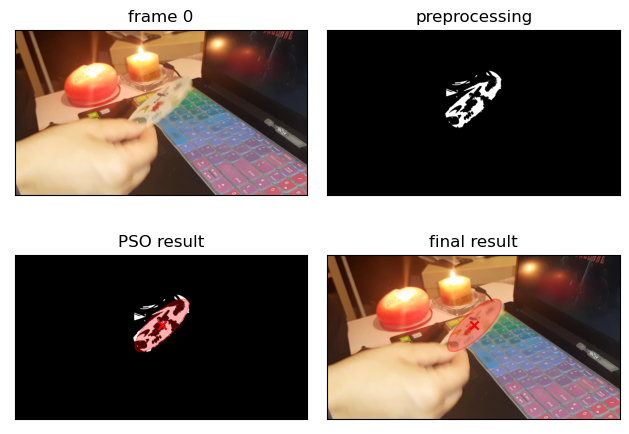

In [5]:
plt.figure()
# plot original image
plt.subplot(2, 2, 1),   plt.title(f"frame {start_frame}")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# plot the preprocessed image
plt.subplot(2, 2, 2)
plt.imshow(img_preprocessed, cmap="gray")
plt.title("preprocessing")

# plot the PSO result on the preprocessed image
plt.subplot(2, 2, 3),   plt.title("PSO result")
plt.imshow(img_preprocessed, cmap="gray")
plt.scatter(x, y, color='red', marker='x')
plt.gca().add_patch(Ellipse((x, y), 2*a, 2*b, angle=theta, color='red', alpha=0.3))

# plot the final result on the original image
plt.subplot(2, 2, 4),   plt.title("final result")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(x, y, color='red', marker='x')
plt.gca().add_patch(Ellipse((x, y), 2*a, 2*b, angle=theta, color='red', alpha=0.3))

plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

# Next Frames
### Use the estimated parameters from the previous frame as prior knowledge
We can use the best global position of the previous frame, $t-1$, as an initial global best position for the current frame, $t$.

Additionally, we can utilize the estimated ellipse's axes, $\hat \alpha_{t-1}, \hat \beta_{t-1}$ to better preprocess the current frame and remove the background more effectively. We calculate the kernel size for the `closing` morphological operation in the preprocessing as:
$65 \leq \lfloor 0.5 \cdot \min(\hat \alpha_{t-1},\, \hat \beta_{t-1})\rceil \leq 105$

In [6]:
start_frame += 1

num_particles = 25
max_iterations = 100
stop_iterations = 6     # stop if no improvement after these iterations
c1 = 1.0                # cognitive parameter
c2 = 1.0                # social parameter
w  = 0.7                # inertia weight
decay = 0.97            # decay of inertia
high_threshold = 190    # highest threshold to try for binarization (if it fails, lower values will be tried automatically)

for i in tqdm(range(start_frame, end_frame)):
    w  = 0.7
    # load each frame
    img = cv2.imread(os.path.join(in_dir, f"{prefix}{str(i).zfill(zero_padding)}.jpg"))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    y_max, x_max = img.shape[:2]
    max_axis = round(np.sqrt(x_max**2 + y_max**2) / 5) # max axis length is 1/5 of the diagonal of the image
    max_angle = 180
    max_position = [x_max, y_max, max_axis, max_axis, max_angle]

    # preprocess the image
    savefile = os.path.join(prepr_dir, f"{prefix}{str(i).zfill(zero_padding)}.png") if SAVE_PREPR else None
    open_size = 150
    close_size = round(0.5 * min(best_position[2], best_position[3]))
    close_size = np.clip(close_size, 65, 105).astype(int)
    threshold = high_threshold
    while True:
        img_preprocessed = preprocess_image_ellipse(img_gray, threshold=threshold, open_size=open_size, close_size=close_size, save_filename=savefile)
        # if img_preprocessed is completely black, try again with lower threshold and open size
        if np.sum(img_preprocessed) > 10:
            break
        threshold -= 10
        open_size -= 10

    # run PSO on the preprocessed image
    particles = initialize_particles(img_preprocessed, num_particles, max_position)
    init_fitness = evaluate_fitness(img_preprocessed, best_position)
    optim = ParticleSwarmOptimizer(num_particles, max_iterations, c1, c2, w, decay, stop_iterations, best_position, init_fitness)
    best_position, best_fitness, _ = optim.optimize(img_preprocessed, particles, max_position)

    # swap the axes if the ellipse is rotated more than 90 degrees
    if best_position[2] < best_position[3]:
        best_position[2], best_position[3] = best_position[3], best_position[2]
        best_position[4] = (best_position[4] + 90) % 180

    # save the estimated ellipse parameters and/or the preprocessed image
    if SAVE_TXTS:
        save_txt(os.path.join(txt_dir, f"{prefix}{i}.txt"), estimated_params=best_position, type='ellipse')
    if SAVE_IMGS:
        filename = os.path.join(img_dir, f"{prefix}{i}.png")
        plot_estimation(img, best_position, title=f"Frame {i}", save_filename=filename, show=False, est_type='ellipse', rgb=True)

100%|██████████| 653/653 [20:31<00:00,  1.89s/it]


In [7]:
# uncomment to create a video from the preprocessed images of dataset2 (video 'dataset3_preprocessed.avi')
# make_video(prepr_dir, 'colorFrame_0', savepath='dataset3_preprocessed.avi', fps=30, width=1920, height=1080, num_pad=5)

In [8]:
# uncomment to create a video from the preprocessed images of dataset2 (video 'dataset3_preprocessed.avi')
# make_video(img_dir, 'colorFrame_0', savepath='dataset3_final.avi', fps=30, width=1234, height=756)